<h3>Student Risk Index (SRI)</h3>

<h5>Introduction and Justification of this Index</h5>
<p> When I found this dataset I thought that the findings here were very interesting because I think early identification of students at risk of underperforming in school or even dropping out is critical and could be very useful for school's around the world, especially school's which might have bad drop out rates or low test scores from students. This dataset addresses multiple areas such as socio-economic factors, behavioural factors and academic factors. Using the key variables I will aim to create three sub-indices. 
<ul>
<li>Academic Risk Index (ARI)</li>
<li>Socioeconomic Risk Index (SERI)</li>
<li>Behavioral Risk Index (BRI)</li>
</ul>
Each sub-index will be based on normalized features and combined into the Student Risk Index (SRI).</p>

<h5>Purpose of this Composite Index</h5>
<p> The Student Risk Index will provide a quantitative measure of the overall risk faced by secondary school students in a variety of areas such as academic performance, behavioral habits, and socioeconomic conditions. This index will form an early warning indicator to help identify students who are at great risk of failure in school.
<h5>The main goals of the SFBI Index</h5>
<ul>
<li> To find which countries offer the most affordable education based on their economic capacity</li>
<li>Identify countries where the tution fees are much higher when compared to GDP per capita.</li>
</ul>

This index will be created using two datasets:

1. Global Tuition Fees & Education Trends 2024
Link: https://www.kaggle.com/datasets/kathrinaroldan/global-tuition-fees-and-education-trends-2024
Key variables:
<ul>
<li>Public university tuition fees</li>
<li>Private university tuition fees</li>
<li>Number of universities</li>
<li>Enrollment counts</li>
<li>Percentage of Private Universities</li>
<li>Scholarship Availability (%) (inversely weighted)</li>
</ul>



<h3>References</h3>
<p>1. Ahmed-Haq, R. (2012) What is economic capacity? Economic News, 18 October. Available at: https://rates.ca/resources/what-is-economic-capacity (Accessed: 19 March 2025).
2. Western Governors University (2022) Affordability and value in higher education. Available at: https://www.wgu.edu/blog/affordability-value-higher-education-advocate-post2211.html (Accessed: 19 March 2025).


In [48]:
#code from class notes
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

student_df = pd.read_csv("student-mat.csv")
student_df


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [51]:
# --- Initial Data Cleaning and Imputation ---

# Copy original dataset
student_df_cleaned = student_df.copy()

# Rename columns
student_df_cleaned = student_df_cleaned.rename(columns={
    'school': 'school',
    'sex': 'gender',
    'age': 'age',
    'address': 'addr_type',
    'famsize': 'fam_size',
    'Pstatus': 'parent_status',
    'Medu': 'medu',
    'Fedu': 'fedu',
    'Mjob': 'mjob',
    'Fjob': 'fjob',
    'reason': 'school_reason',
    'guardian': 'guardian',
    'traveltime': 'travel_time',
    'studytime': 'study_time',
    'failures': 'failures',
    'schoolsup': 'school_sup',
    'famsup': 'fam_sup',
    'paid': 'paid_classes',
    'activities': 'activities',
    'nursery': 'nursery',
    'higher': 'wants_higher_ed',
    'internet': 'internet',
    'romantic': 'romantic_rel',
    'famrel': 'fam_rel',
    'freetime': 'free_time',
    'goout': 'go_out',
    'Dalc': 'alc_workday',
    'Walc': 'alc_weekend',
    'health': 'health',
    'absences': 'absences',
    'G1': 'grade1',
    'G2': 'grade2',
    'G3': 'grade3'
})

# Drop irrelevant columns
columns_to_drop = ['school', 'mjob', 'fjob', 'school_reason', 'guardian']
student_df_cleaned = student_df_cleaned.drop(columns=[col for col in columns_to_drop if col in student_df_cleaned.columns])

# Convert all object columns to category
for col in student_df_cleaned.select_dtypes(include='object').columns:
    student_df_cleaned[col] = student_df_cleaned[col].astype('category')

# Encode all categorical variables using .cat.codes
for col in student_df_cleaned.select_dtypes(include='category').columns:
    student_df_cleaned[col] = student_df_cleaned[col].cat.codes

# Fill missing numeric values with mean
for col in student_df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    student_df_cleaned[col] = student_df_cleaned[col].fillna(student_df_cleaned[col].mean())

# Drop rows where final grades are missing (they are your outcome)
student_df_cleaned = student_df_cleaned.dropna(subset=['grade1', 'grade2', 'grade3'])

# Print cleaned data
print(student_df_cleaned.head())


   gender  age  addr_type  fam_size  parent_status  medu  fedu  travel_time  \
0       0   18          1         0              0     4     4            2   
1       0   17          1         0              1     1     1            1   
2       0   15          1         1              1     1     1            1   
3       0   15          1         0              1     4     2            1   
4       0   16          1         0              1     3     3            1   

   study_time  failures  ...  fam_rel  free_time  go_out  alc_workday  \
0           2         0  ...        4          3       4            1   
1           2         0  ...        5          3       3            1   
2           2         3  ...        4          3       2            2   
3           3         0  ...        3          2       2            1   
4           2         0  ...        4          3       2            1   

   alc_weekend  health  absences  grade1  grade2  grade3  
0            1       3     

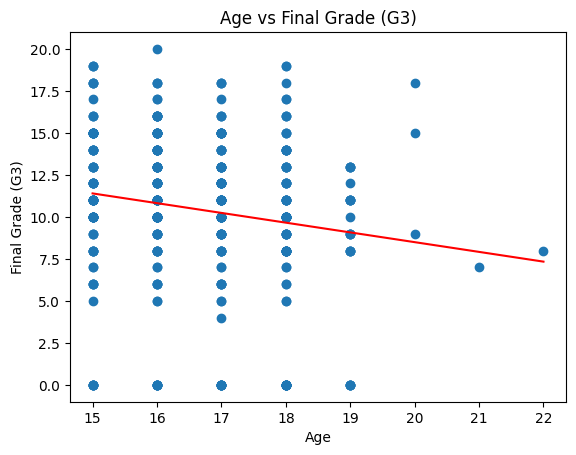

PearsonRResult(statistic=np.float64(-0.1615794381383402), pvalue=np.float64(0.0012714385457178168))

In [53]:
plt.figure()
plt.title('Age vs Final Grade (G3)')
plt.xlabel('Age')
plt.ylabel('Final Grade (G3)')
plt.scatter(student_df_cleaned.age, student_df_cleaned.grade3)
fit = np.polyfit(student_df_cleaned.age, student_df_cleaned.grade3, 1)
x_vals = np.linspace(student_df_cleaned.age.min(), student_df_cleaned.age.max(), 100)
y_vals = np.poly1d(fit)(x_vals)
plt.plot(x_vals, y_vals, color='red')
plt.show()
# Calculate Pearson correlation
corr_age_grade3 = pearsonr(student_df_cleaned.age, student_df_cleaned.grade3)
corr_age_grade3

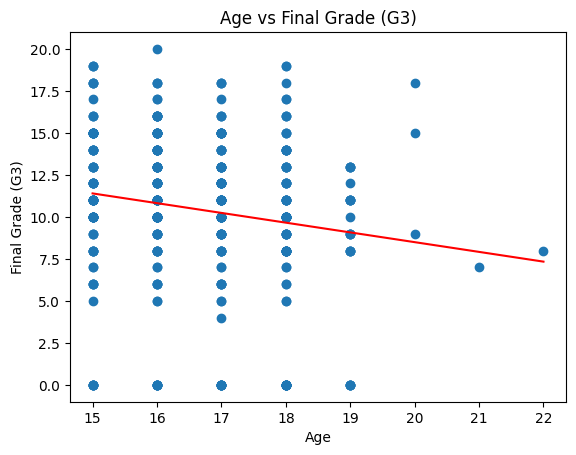

age vs grade3 → Pearson r: -0.1616, p-value: 0.001271


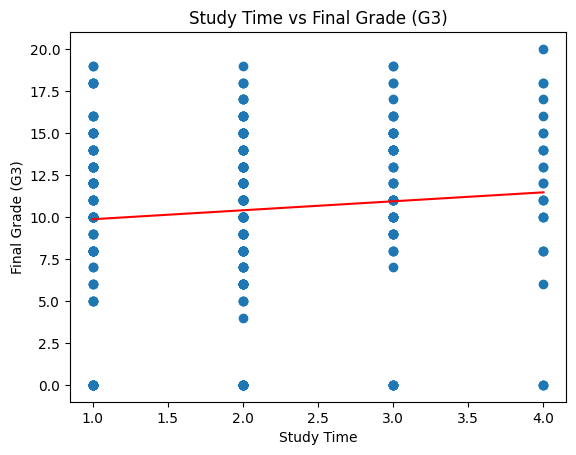

study_time vs grade3 → Pearson r: 0.0978, p-value: 0.05206


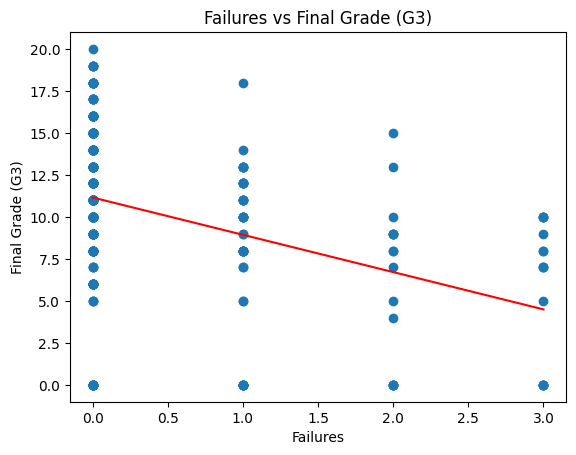

failures vs grade3 → Pearson r: -0.3604, p-value: 1.466e-13


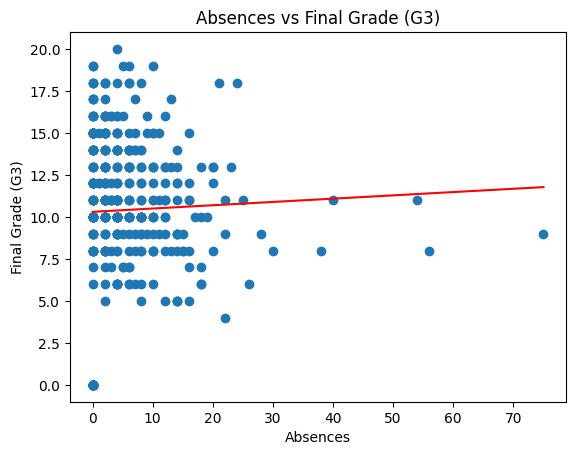

absences vs grade3 → Pearson r: 0.0342, p-value: 0.4973


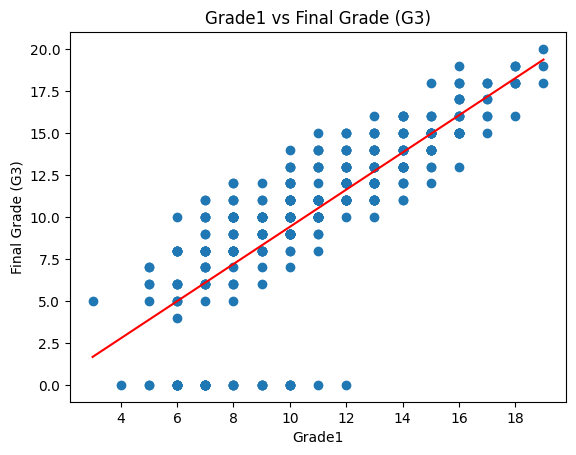

grade1 vs grade3 → Pearson r: 0.8015, p-value: 9.001e-90


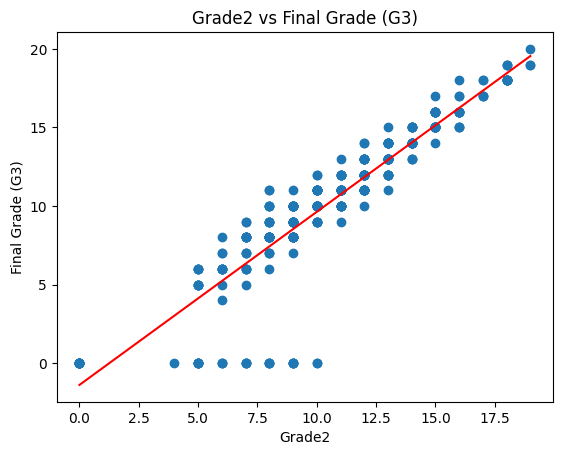

grade2 vs grade3 → Pearson r: 0.9049, p-value: 7.626e-148


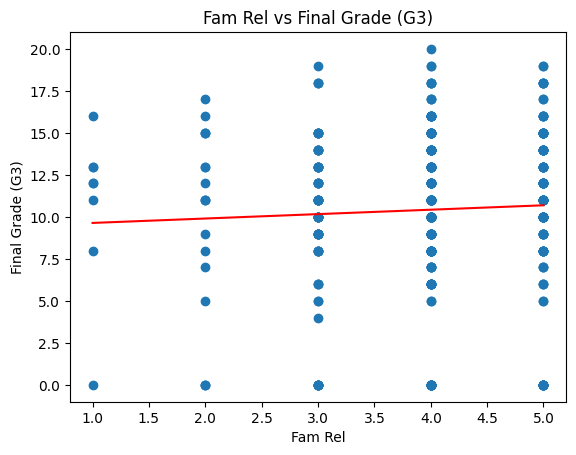

fam_rel vs grade3 → Pearson r: 0.0514, p-value: 0.3086


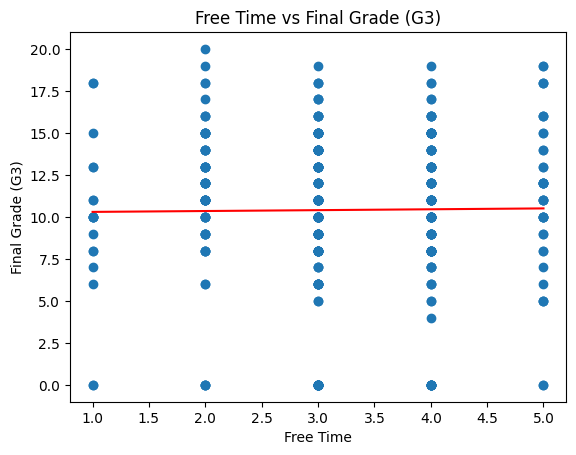

free_time vs grade3 → Pearson r: 0.0113, p-value: 0.8227


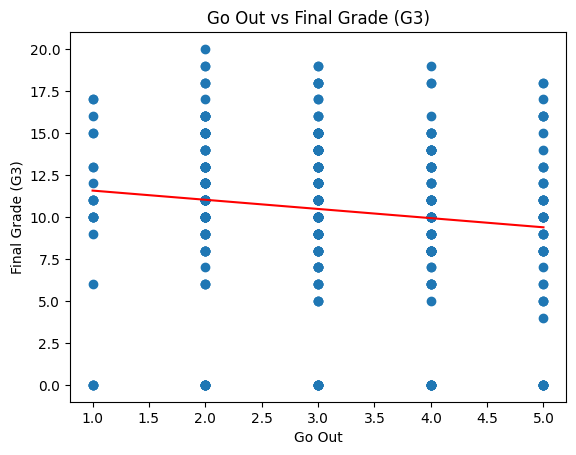

go_out vs grade3 → Pearson r: -0.1328, p-value: 0.008229


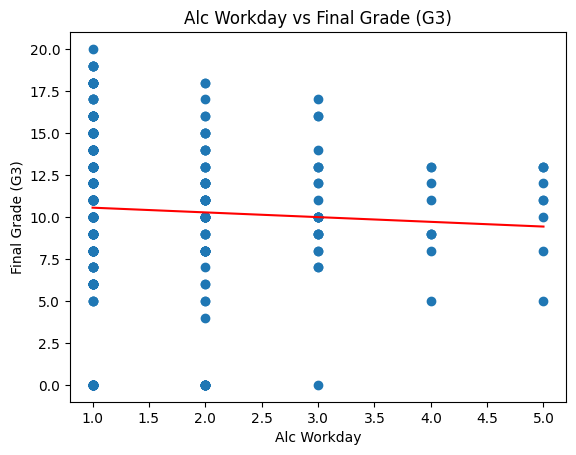

alc_workday vs grade3 → Pearson r: -0.0547, p-value: 0.2785


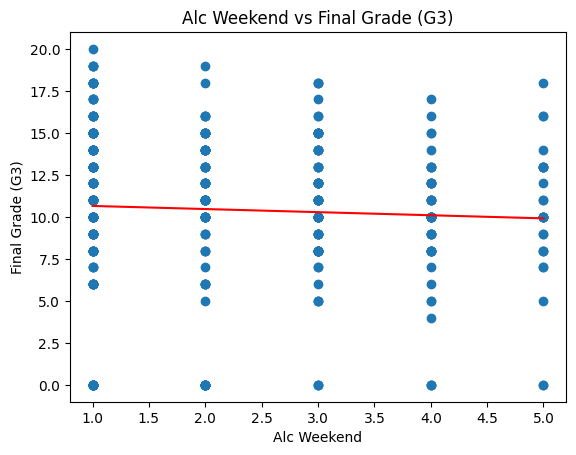

alc_weekend vs grade3 → Pearson r: -0.0519, p-value: 0.3032


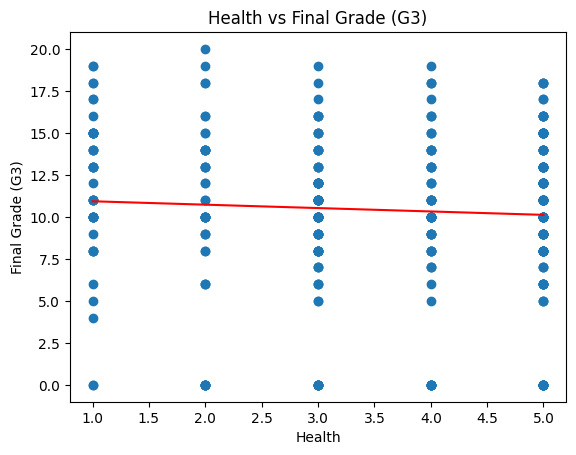

health vs grade3 → Pearson r: -0.0613, p-value: 0.2239
       Variable  Correlation Coefficient        P-Value
0           age                -0.161579   1.271439e-03
1    study_time                 0.097820   5.206115e-02
2      failures                -0.360415   1.465663e-13
3      absences                 0.034247   4.973318e-01
4        grade1                 0.801468   9.001430e-90
5        grade2                 0.904868  7.625719e-148
6       fam_rel                 0.051363   3.085520e-01
7     free_time                 0.011307   8.227402e-01
8        go_out                -0.132791   8.229000e-03
9   alc_workday                -0.054660   2.784915e-01
10  alc_weekend                -0.051939   3.031521e-01
11       health                -0.061335   2.238770e-01


In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import pandas as pd

# Replace this with your actual cleaned DataFrame
# student_df_cleaned = pd.read_csv('your_cleaned_file.csv')

# List of independent variables to compare against grade3
independent_vars = [
    'age', 'study_time', 'failures', 'absences',
    'grade1', 'grade2', 'fam_rel', 'free_time',
    'go_out', 'alc_workday', 'alc_weekend', 'health'
]

# Store correlation results
correlation_results = []

# Generate scatter plots and compute correlations
for var in independent_vars:
    plt.figure()
    plt.title(f'{var.replace("_", " ").title()} vs Final Grade (G3)')
    plt.xlabel(var.replace("_", " ").title())
    plt.ylabel('Final Grade (G3)')
    plt.scatter(student_df_cleaned[var], student_df_cleaned['grade3'])
    
    # Linear regression line
    fit = np.polyfit(student_df_cleaned[var], student_df_cleaned['grade3'], 1)
    x_vals = np.linspace(student_df_cleaned[var].min(), student_df_cleaned[var].max(), 100)
    y_vals = np.poly1d(fit)(x_vals)
    plt.plot(x_vals, y_vals, color='red')
    plt.show()

    # Pearson correlation
    corr = pearsonr(student_df_cleaned[var], student_df_cleaned['grade3'])
    print(f"{var} vs grade3 → Pearson r: {corr[0]:.4f}, p-value: {corr[1]:.4g}")
    correlation_results.append((var, corr[0], corr[1]))

# Convert results to DataFrame for reference
correlation_df = pd.DataFrame(correlation_results, columns=['Variable', 'Correlation Coefficient', 'P-Value'])
print(correlation_df)


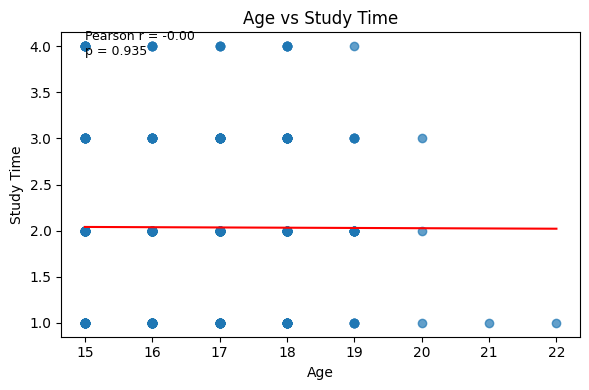

age vs study_time → Pearson r: -0.0041, p-value: 0.9346


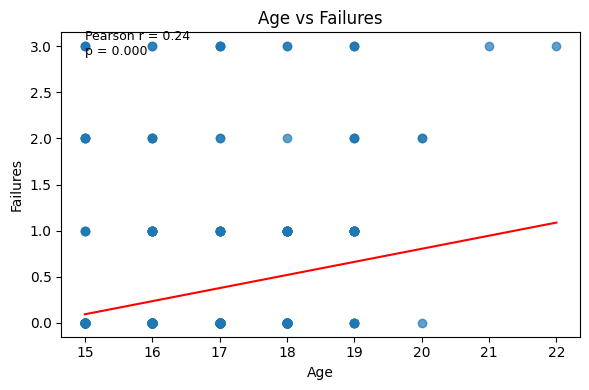

age vs failures → Pearson r: 0.2437, p-value: 9.512e-07


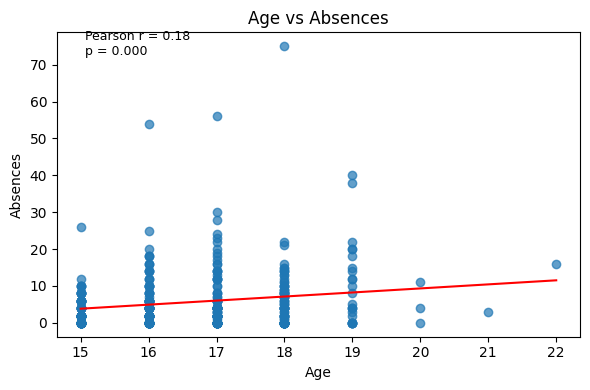

age vs absences → Pearson r: 0.1752, p-value: 0.0004675


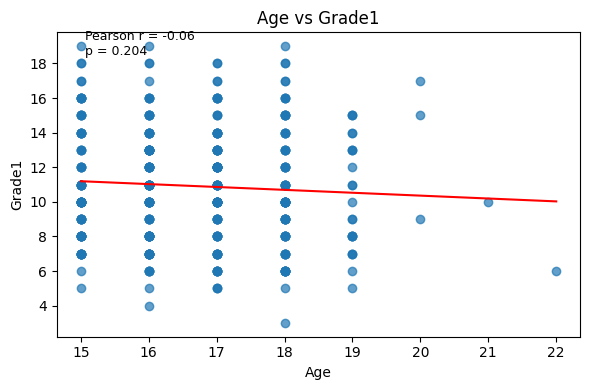

age vs grade1 → Pearson r: -0.0641, p-value: 0.2038


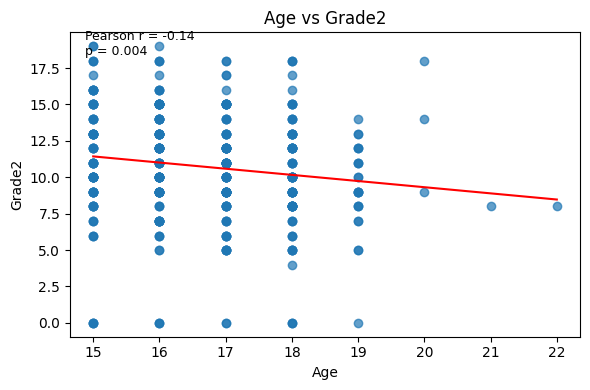

age vs grade2 → Pearson r: -0.1435, p-value: 0.004273


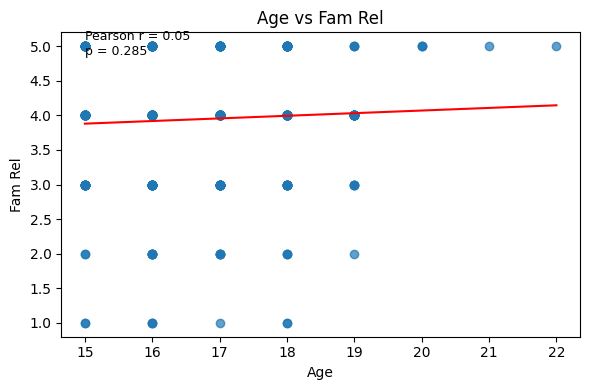

age vs fam_rel → Pearson r: 0.0539, p-value: 0.2849


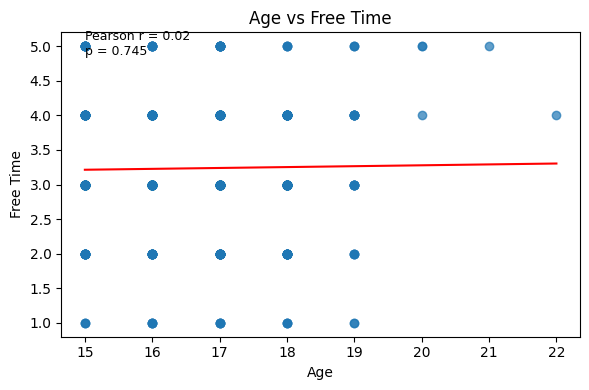

age vs free_time → Pearson r: 0.0164, p-value: 0.7447


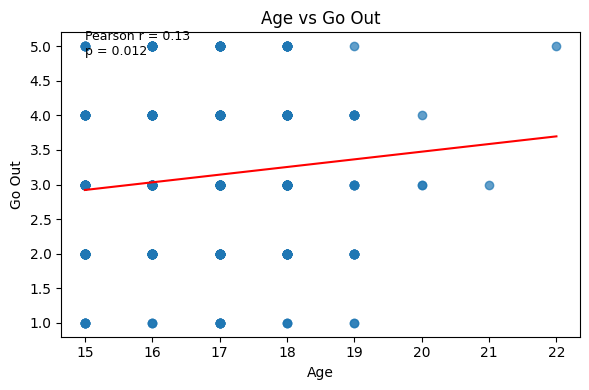

age vs go_out → Pearson r: 0.1270, p-value: 0.01155


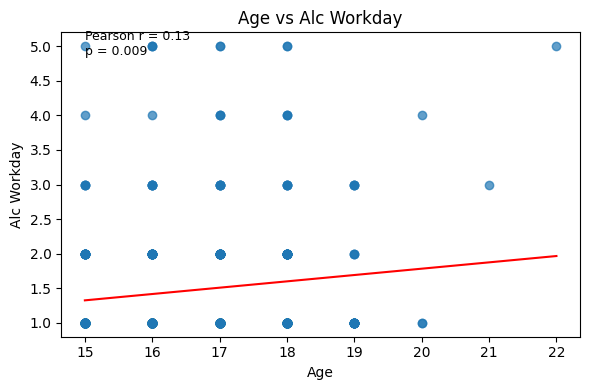

age vs alc_workday → Pearson r: 0.1311, p-value: 0.009079


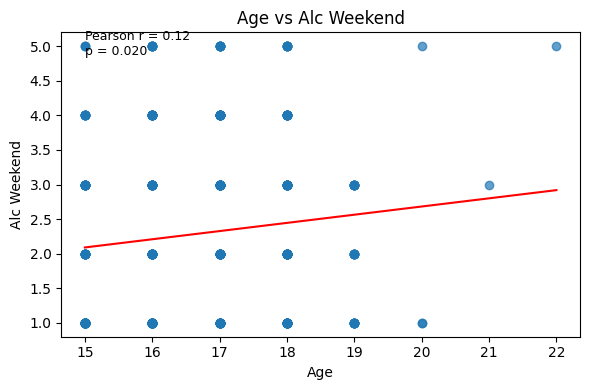

age vs alc_weekend → Pearson r: 0.1173, p-value: 0.01973


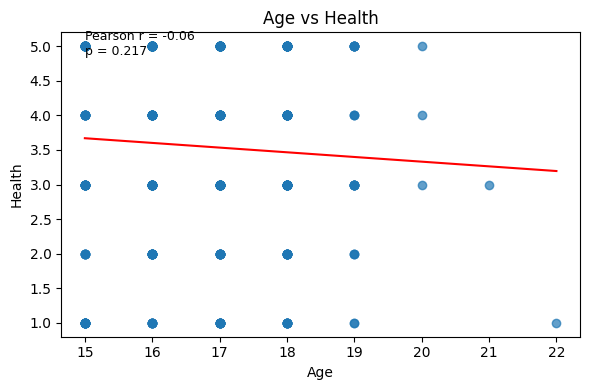

age vs health → Pearson r: -0.0622, p-value: 0.2175


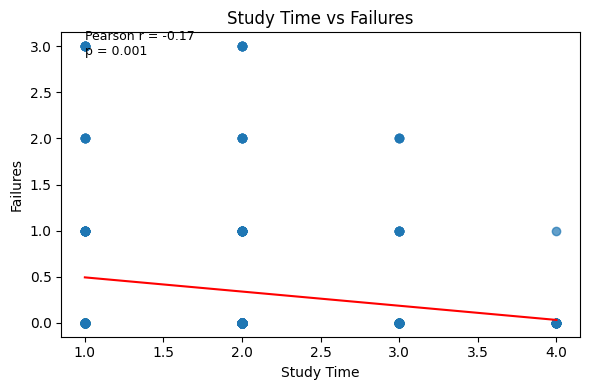

study_time vs failures → Pearson r: -0.1736, p-value: 0.0005304


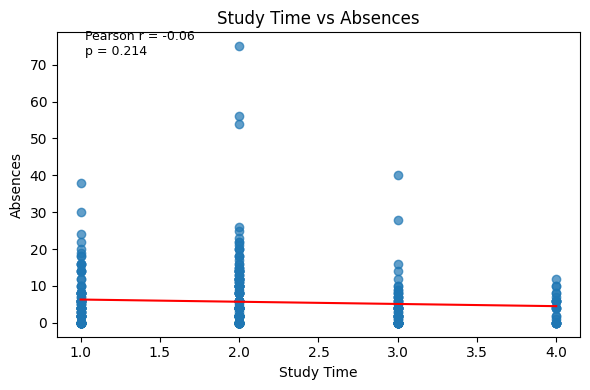

study_time vs absences → Pearson r: -0.0627, p-value: 0.2137


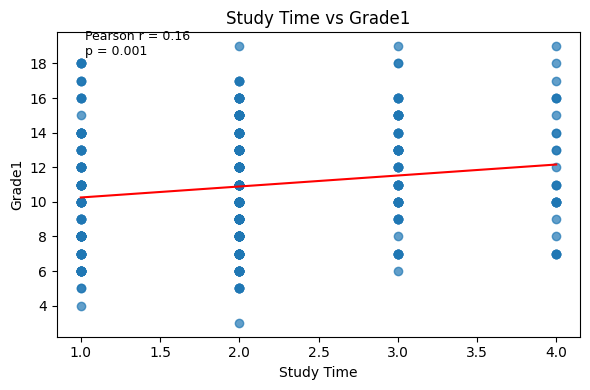

study_time vs grade1 → Pearson r: 0.1606, p-value: 0.001361


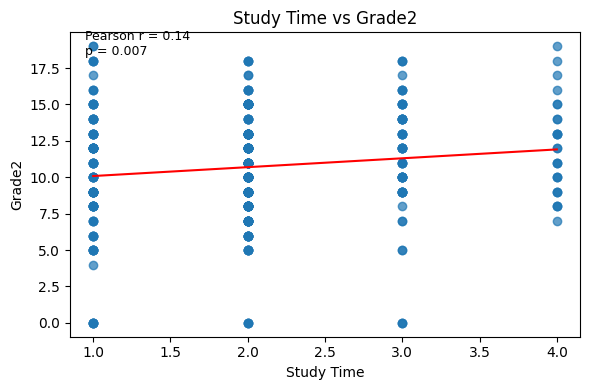

study_time vs grade2 → Pearson r: 0.1359, p-value: 0.00684


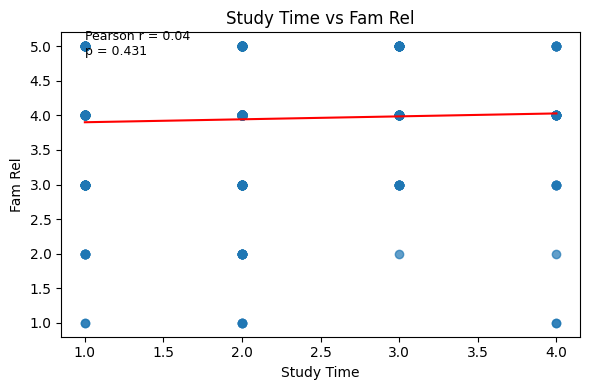

study_time vs fam_rel → Pearson r: 0.0397, p-value: 0.431


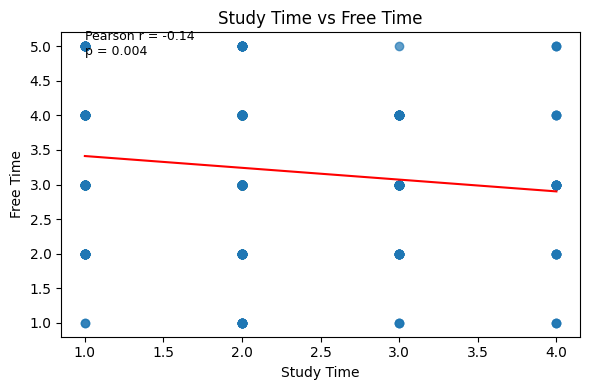

study_time vs free_time → Pearson r: -0.1432, p-value: 0.004349


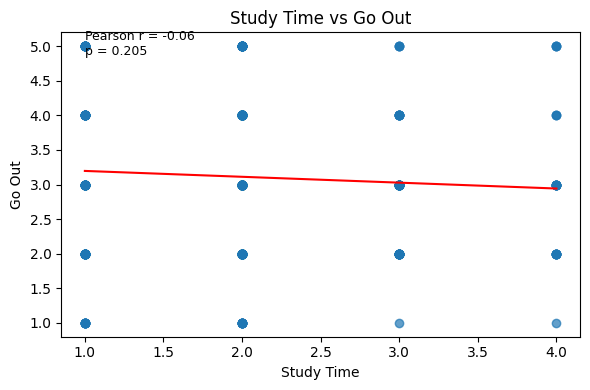

study_time vs go_out → Pearson r: -0.0639, p-value: 0.205


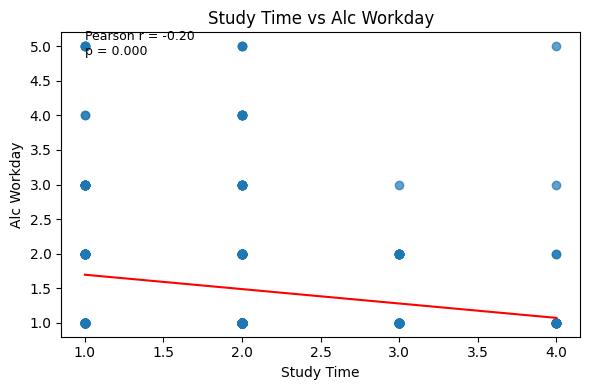

study_time vs alc_workday → Pearson r: -0.1960, p-value: 8.797e-05


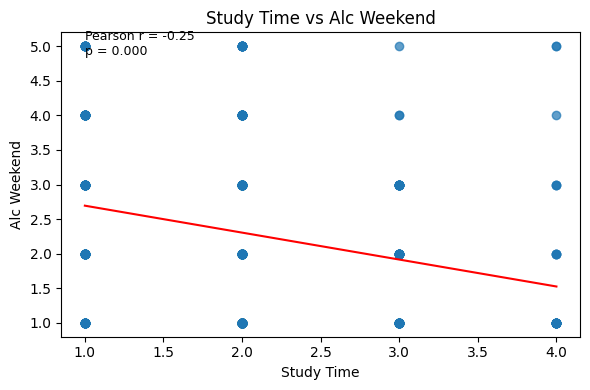

study_time vs alc_weekend → Pearson r: -0.2538, p-value: 3.191e-07


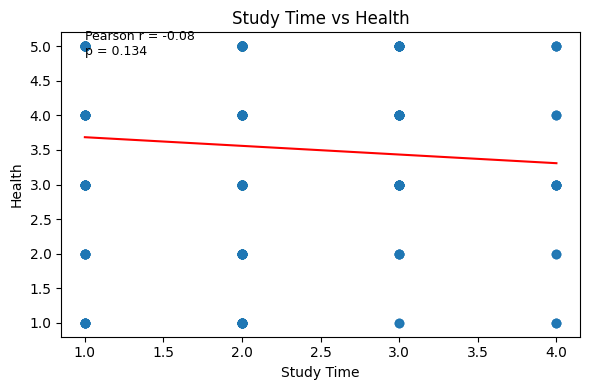

study_time vs health → Pearson r: -0.0756, p-value: 0.1336


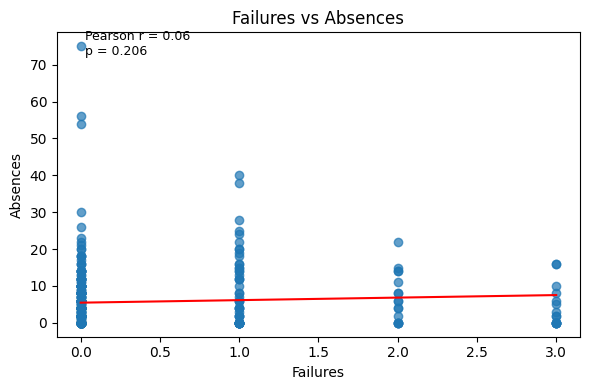

failures vs absences → Pearson r: 0.0637, p-value: 0.2063


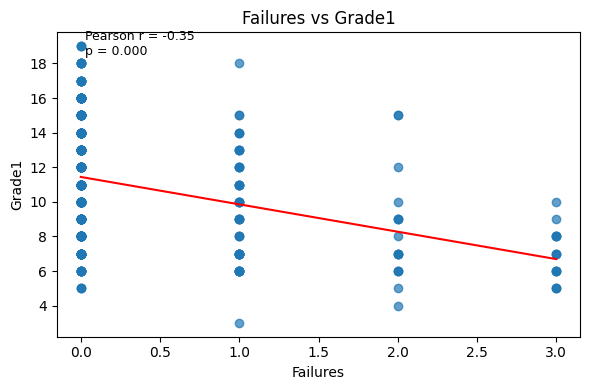

failures vs grade1 → Pearson r: -0.3547, p-value: 3.727e-13


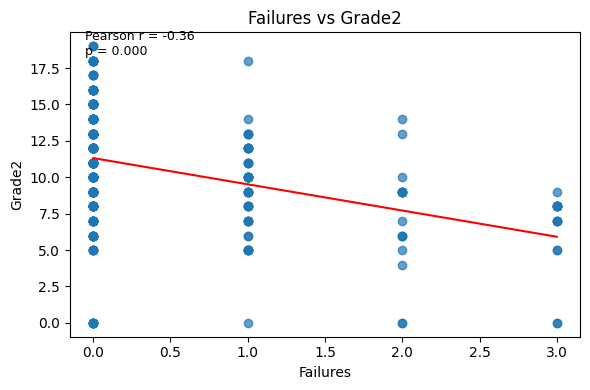

failures vs grade2 → Pearson r: -0.3559, p-value: 3.078e-13


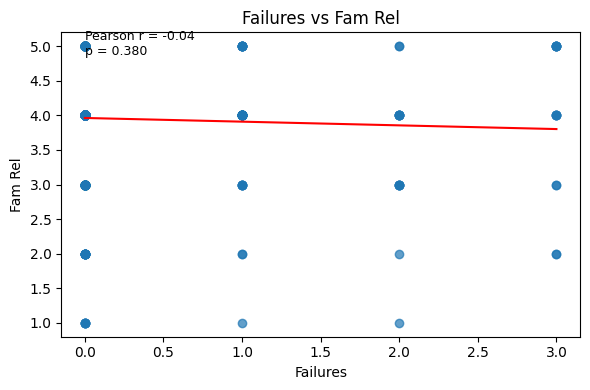

failures vs fam_rel → Pearson r: -0.0443, p-value: 0.3795


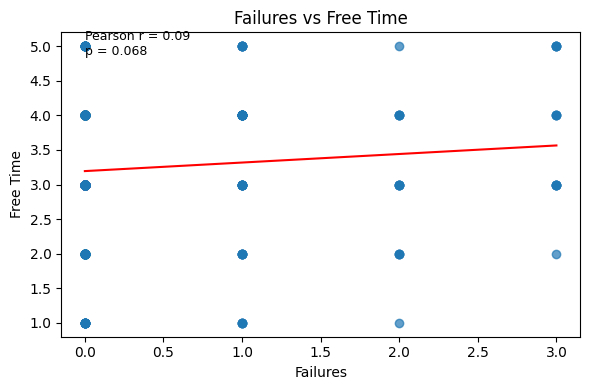

failures vs free_time → Pearson r: 0.0920, p-value: 0.06781


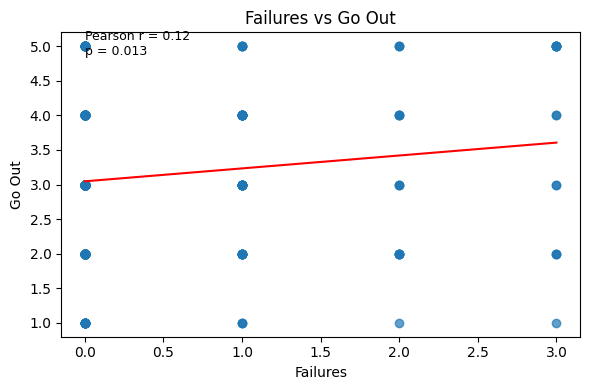

failures vs go_out → Pearson r: 0.1246, p-value: 0.01323


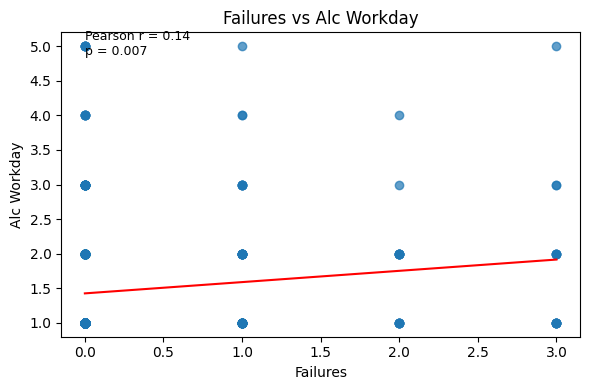

failures vs alc_workday → Pearson r: 0.1360, p-value: 0.006771


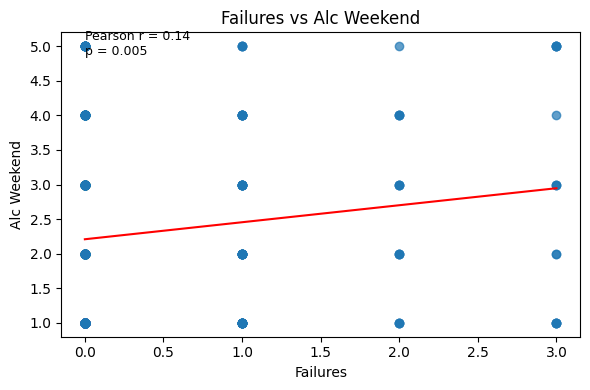

failures vs alc_weekend → Pearson r: 0.1420, p-value: 0.004701


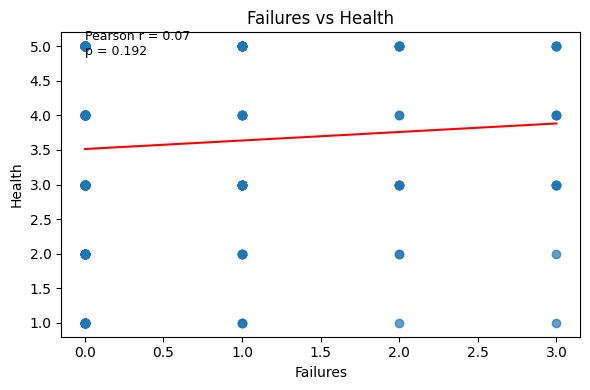

failures vs health → Pearson r: 0.0658, p-value: 0.1917


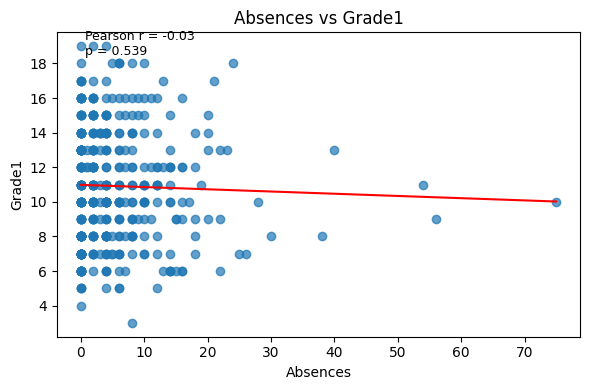

absences vs grade1 → Pearson r: -0.0310, p-value: 0.539


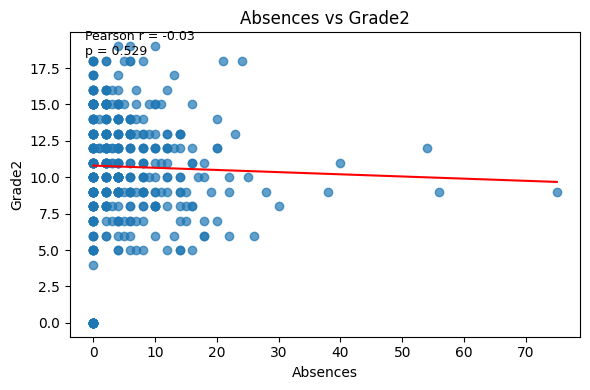

absences vs grade2 → Pearson r: -0.0318, p-value: 0.5289


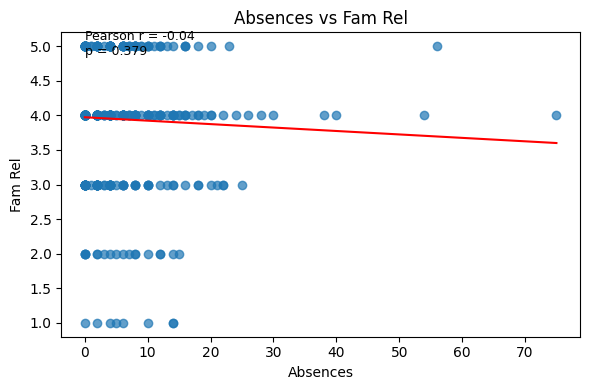

absences vs fam_rel → Pearson r: -0.0444, p-value: 0.3793


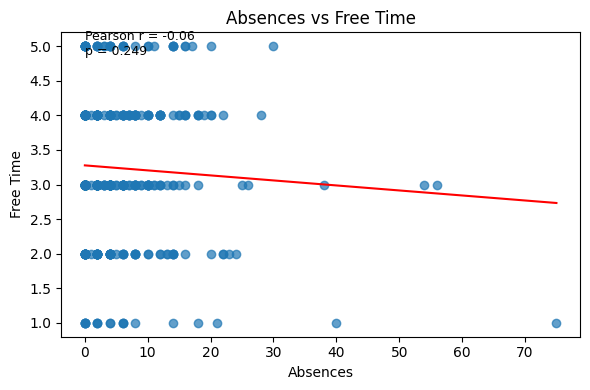

absences vs free_time → Pearson r: -0.0581, p-value: 0.2495


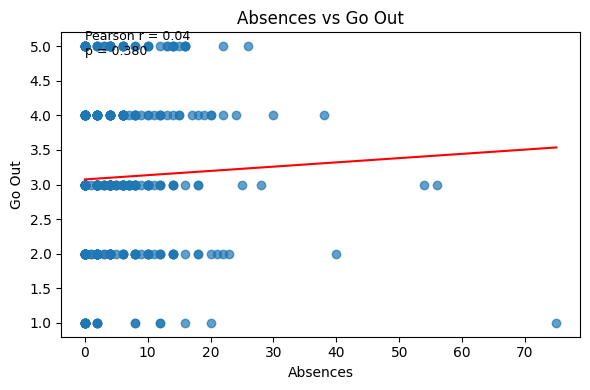

absences vs go_out → Pearson r: 0.0443, p-value: 0.3799


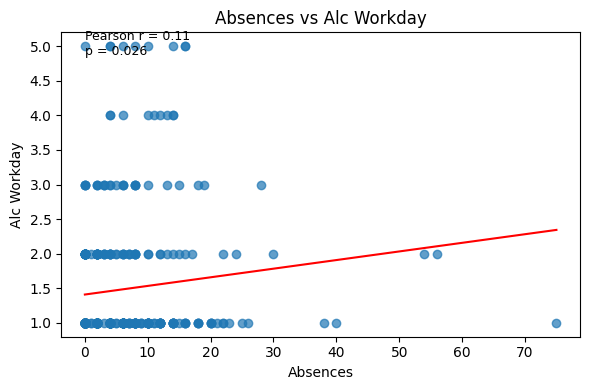

absences vs alc_workday → Pearson r: 0.1119, p-value: 0.02614


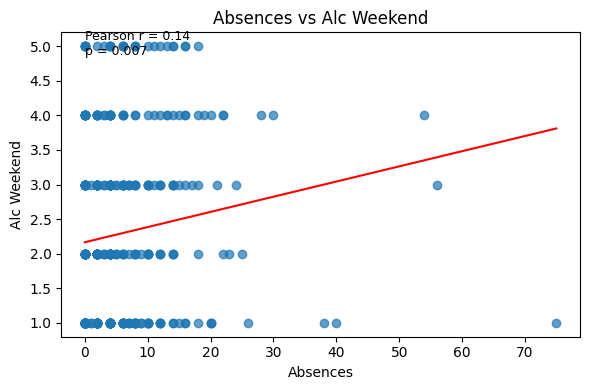

absences vs alc_weekend → Pearson r: 0.1363, p-value: 0.006671


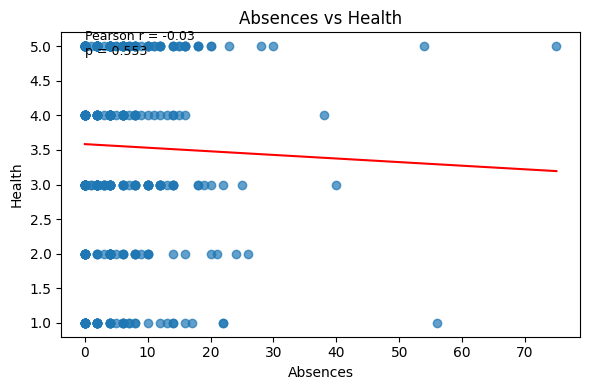

absences vs health → Pearson r: -0.0299, p-value: 0.553


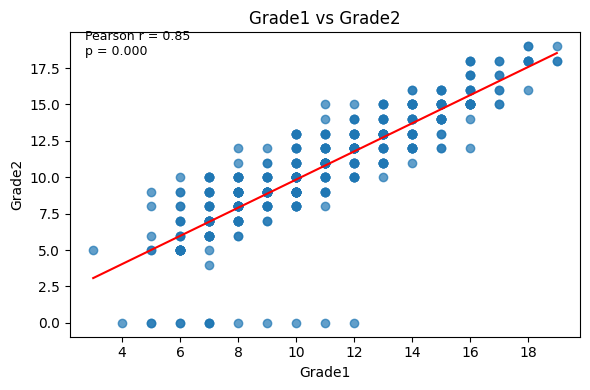

grade1 vs grade2 → Pearson r: 0.8521, p-value: 1.441e-112


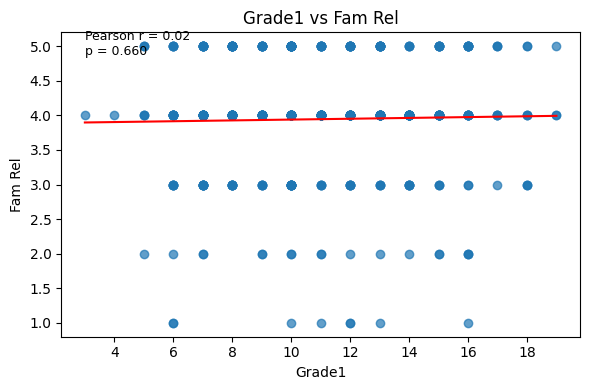

grade1 vs fam_rel → Pearson r: 0.0222, p-value: 0.6605


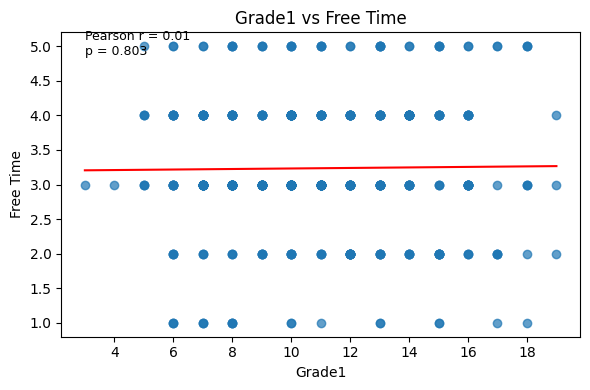

grade1 vs free_time → Pearson r: 0.0126, p-value: 0.8027


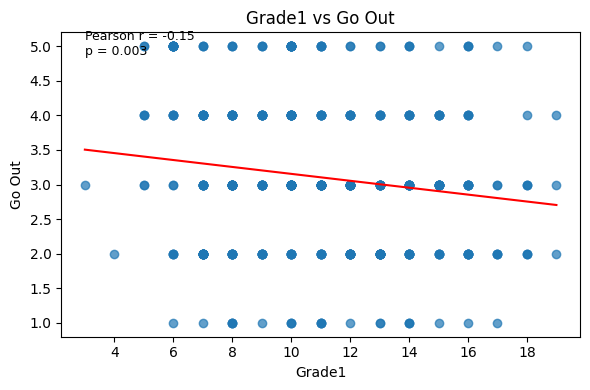

grade1 vs go_out → Pearson r: -0.1491, p-value: 0.002972


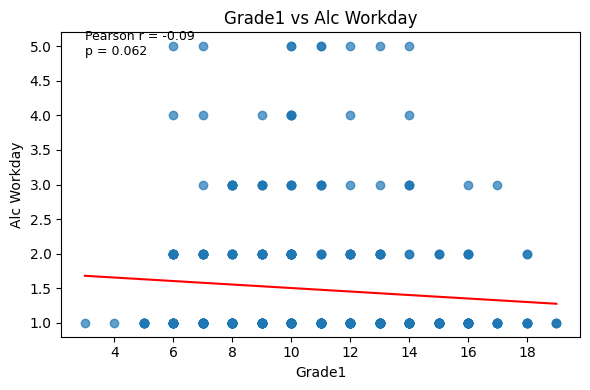

grade1 vs alc_workday → Pearson r: -0.0942, p-value: 0.06154


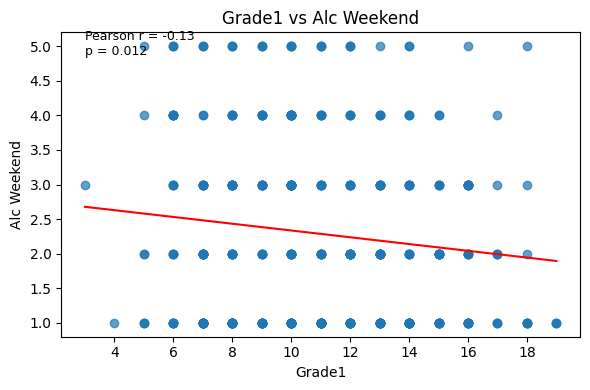

grade1 vs alc_weekend → Pearson r: -0.1262, p-value: 0.01208


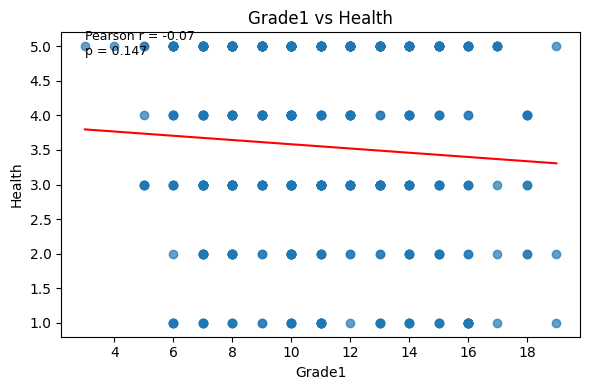

grade1 vs health → Pearson r: -0.0732, p-value: 0.1466


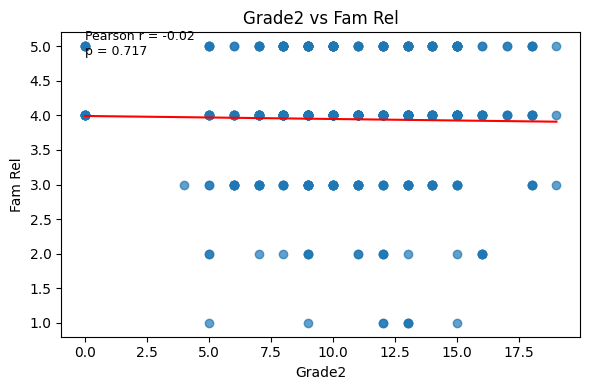

grade2 vs fam_rel → Pearson r: -0.0183, p-value: 0.7172


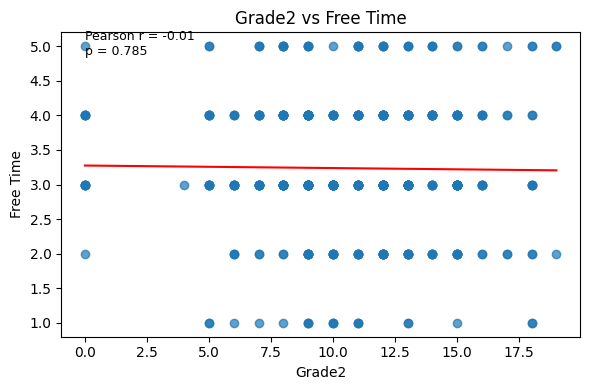

grade2 vs free_time → Pearson r: -0.0138, p-value: 0.7849


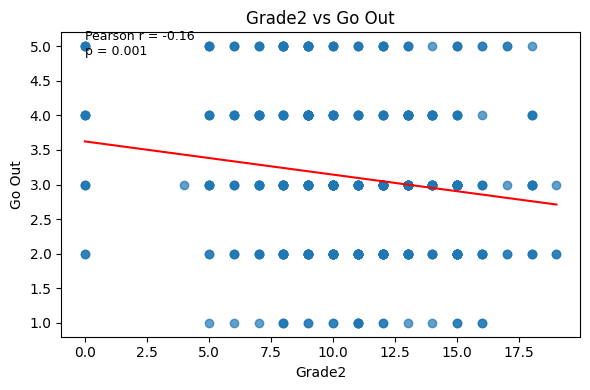

grade2 vs go_out → Pearson r: -0.1623, p-value: 0.001213


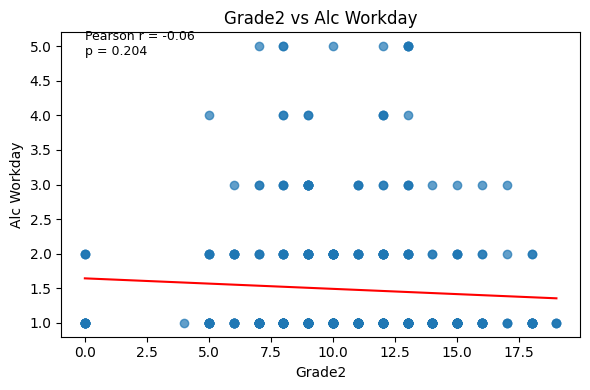

grade2 vs alc_workday → Pearson r: -0.0641, p-value: 0.2035


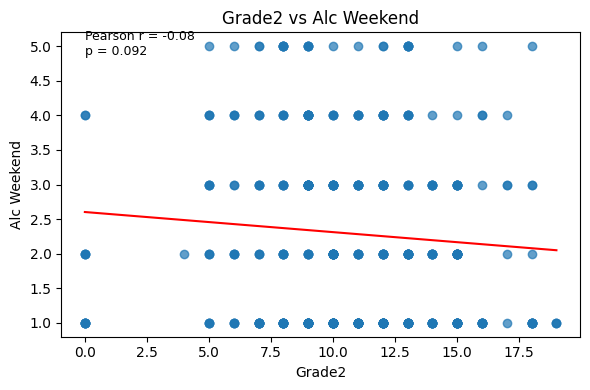

grade2 vs alc_weekend → Pearson r: -0.0849, p-value: 0.09187


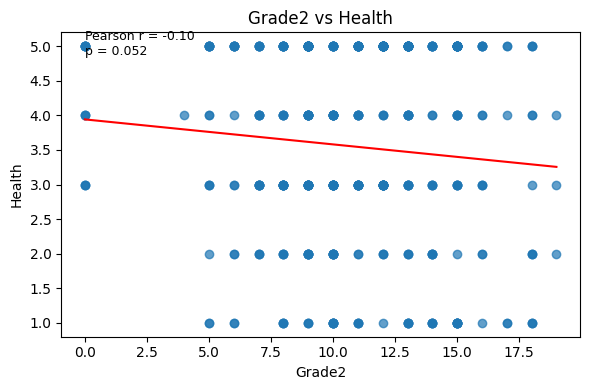

grade2 vs health → Pearson r: -0.0977, p-value: 0.0523


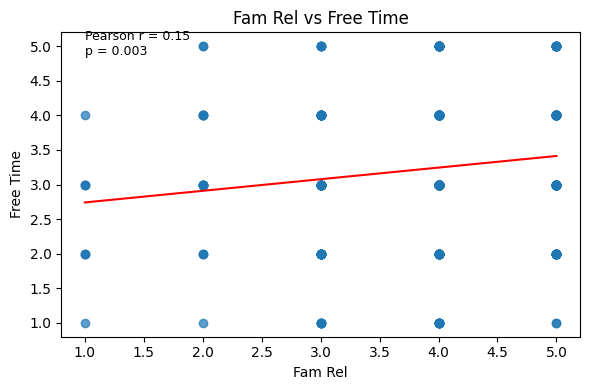

fam_rel vs free_time → Pearson r: 0.1507, p-value: 0.002675


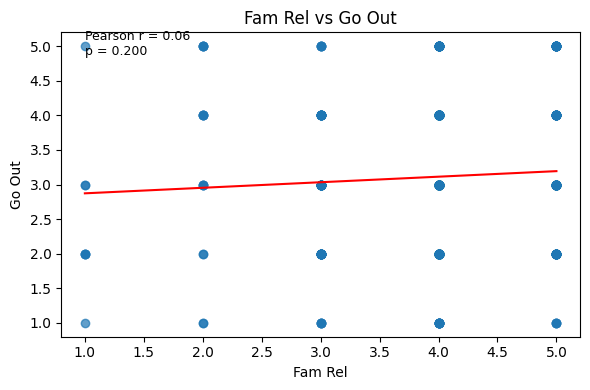

fam_rel vs go_out → Pearson r: 0.0646, p-value: 0.2004


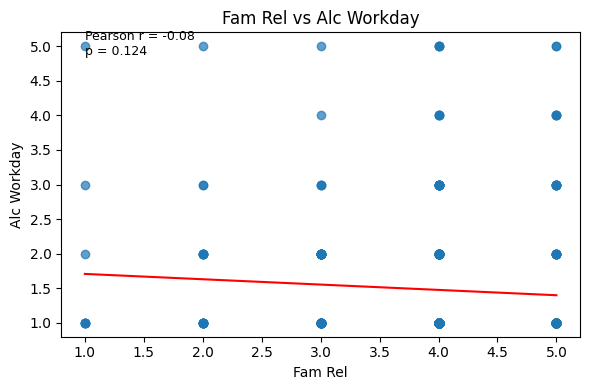

fam_rel vs alc_workday → Pearson r: -0.0776, p-value: 0.1237


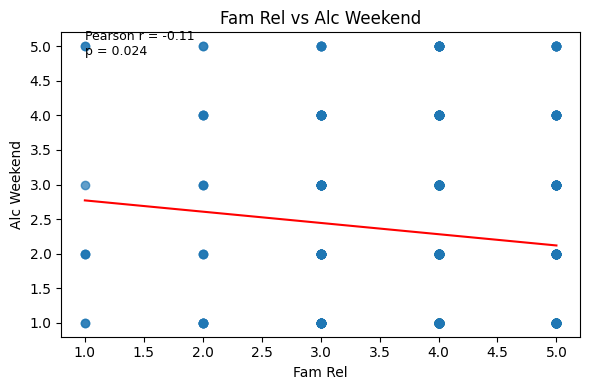

fam_rel vs alc_weekend → Pearson r: -0.1134, p-value: 0.02421


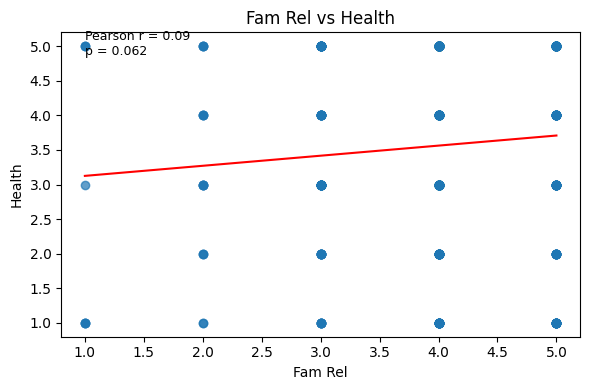

fam_rel vs health → Pearson r: 0.0941, p-value: 0.06183


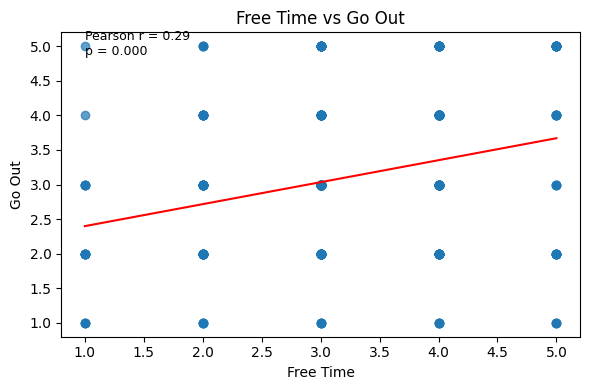

free_time vs go_out → Pearson r: 0.2850, p-value: 8.083e-09


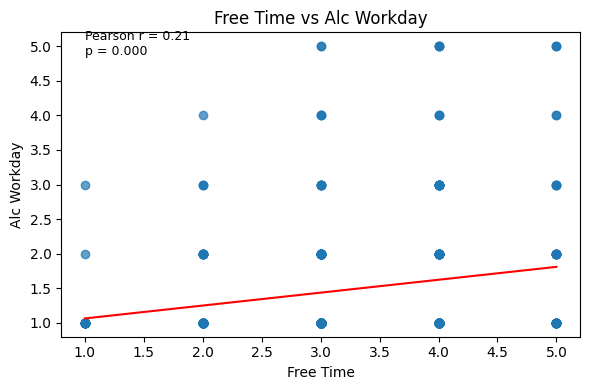

free_time vs alc_workday → Pearson r: 0.2090, p-value: 2.827e-05


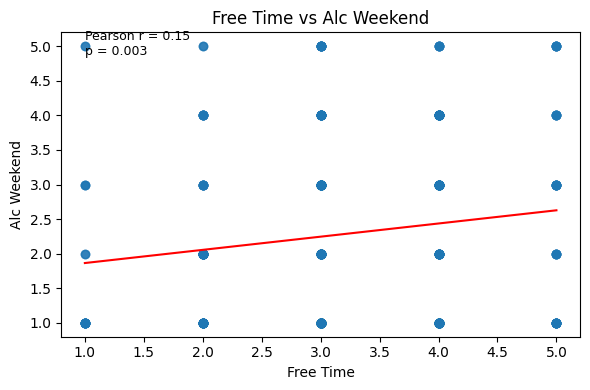

free_time vs alc_weekend → Pearson r: 0.1478, p-value: 0.003232


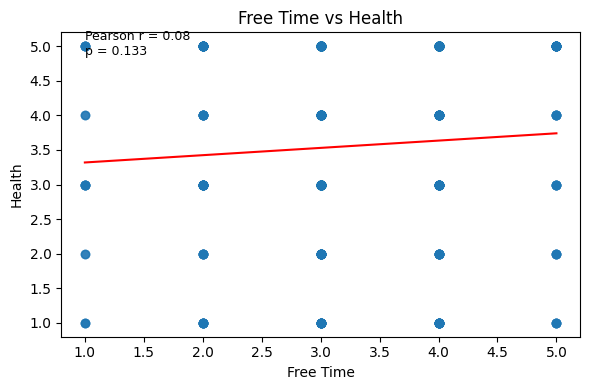

free_time vs health → Pearson r: 0.0757, p-value: 0.133


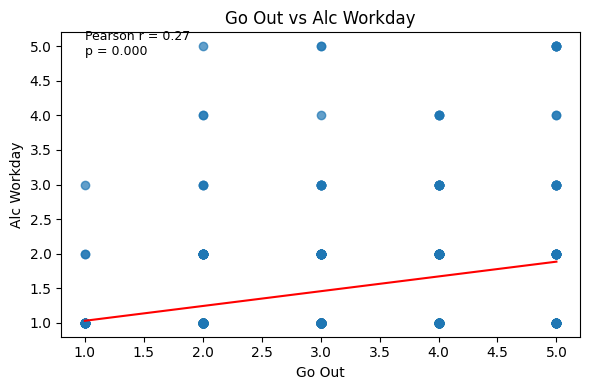

go_out vs alc_workday → Pearson r: 0.2670, p-value: 7.137e-08


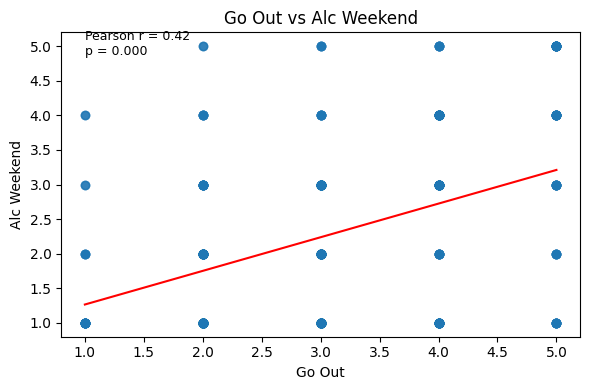

go_out vs alc_weekend → Pearson r: 0.4204, p-value: 2.402e-18


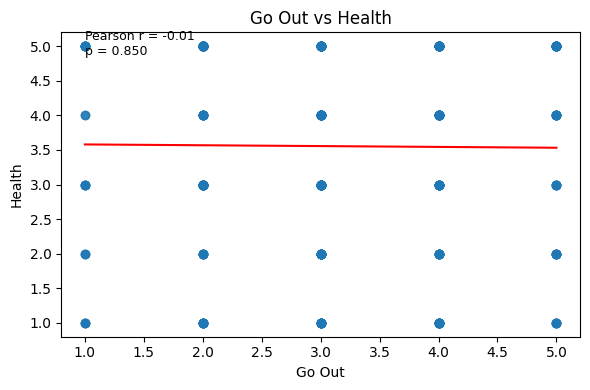

go_out vs health → Pearson r: -0.0096, p-value: 0.8495


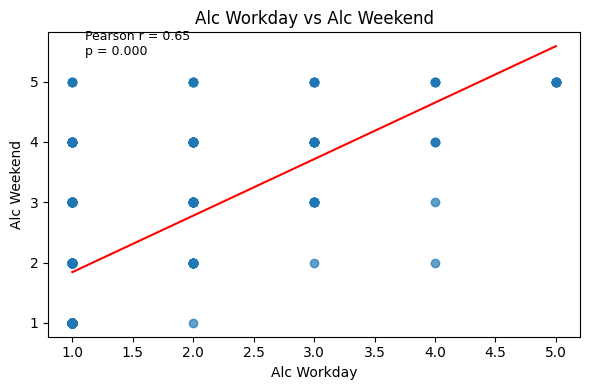

alc_workday vs alc_weekend → Pearson r: 0.6475, p-value: 2.548e-48


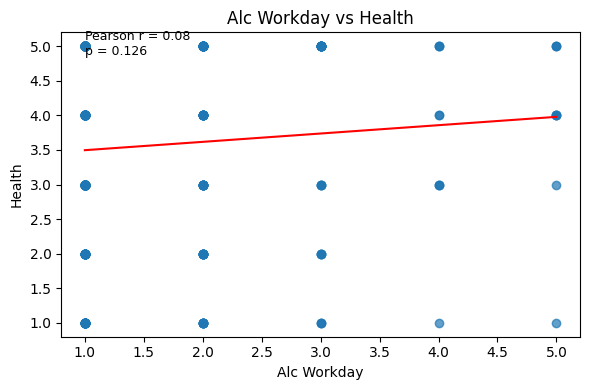

alc_workday vs health → Pearson r: 0.0772, p-value: 0.1257


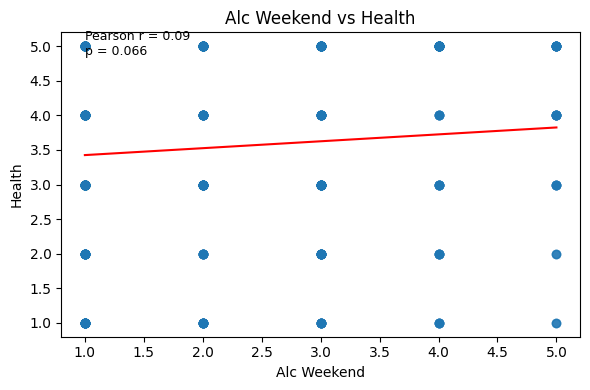

alc_weekend vs health → Pearson r: 0.0925, p-value: 0.06635


In [56]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import itertools

# Define variables to check for multicollinearity
variables = [
    'age', 'study_time', 'failures', 'absences',
    'grade1', 'grade2', 'fam_rel', 'free_time',
    'go_out', 'alc_workday', 'alc_weekend', 'health'
]

# Loop through all unique variable pairs
for var1, var2 in itertools.combinations(variables, 2):
    x = student_df_cleaned[var1]
    y = student_df_cleaned[var2]

    # Compute regression line
    fit = np.polyfit(x, y, 1)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = np.poly1d(fit)(x_vals)

    # Compute correlation
    corr, p_val = pearsonr(x, y)

    # Plot with regression line and correlation annotation
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.7)
    plt.plot(x_vals, y_vals, color='red')
    plt.xlabel(var1.replace('_', ' ').title())
    plt.ylabel(var2.replace('_', ' ').title())
    plt.title(f'{var1.replace("_", " ").title()} vs {var2.replace("_", " ").title()}')
    plt.figtext(0.15, 0.85, f'Pearson r = {corr:.2f}\np = {p_val:.3f}', fontsize=9, ha='left')
    plt.tight_layout()
    plt.show()

    print(f"{var1} vs {var2} → Pearson r: {corr:.4f}, p-value: {p_val:.4g}")


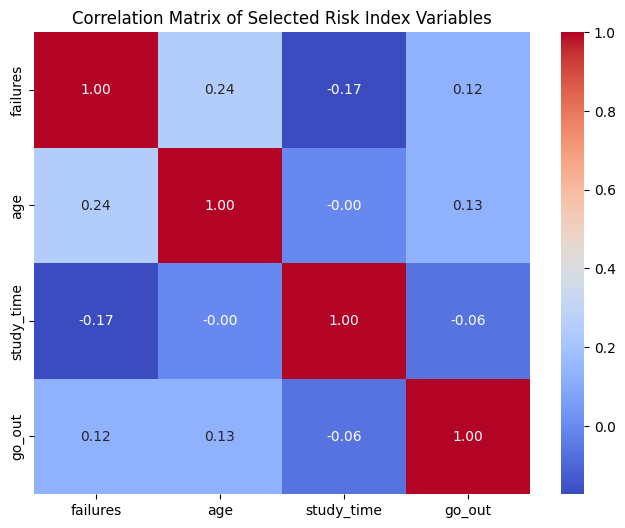

Highly Correlated Pairs (|r| > 0.8):


In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Only include selected variables used in the index
selected_vars = ['failures', 'age', 'study_time', 'go_out']
subset_df = student_df_cleaned[selected_vars]

# Generate the correlation matrix
corr_matrix = subset_df.corr()

# Visualize the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Risk Index Variables")
plt.show()

# Find and print high correlation pairs (> 0.8 or < -0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

# Print high correlation pairs
print("Highly Correlated Pairs (|r| > 0.8):")
for var1, var2, corr_val in high_corr_pairs:
    print(f"{var1} vs {var2}: r = {corr_val:.2f}")


In [60]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Reshape X (independent variable) and define y (dependent variable)
X = student_df_cleaned[['failures', 'age', 'study_time', 'go_out']]
# Define the dependent variable
y = student_df_cleaned['grade3']
# Add a constant to the independent variable for the intercept
X = sm.add_constant(X)
# Fit the model using statsmodels
model = sm.OLS(y, X).fit()
# Print the summary of the regression
print(model.summary())

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# R-squared (how much variance is explained)
r_sq = model.score(X, y)
print(f"R² score: {r_sq:.3f}")


                            OLS Regression Results                            
Dep. Variable:                 grade3   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     16.34
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           2.19e-12
Time:                        17:42:02   Log-Likelihood:                -1130.6
No. Observations:                 395   AIC:                             2271.
Df Residuals:                     390   BIC:                             2291.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0147      2.932      5.462      0.0

In [64]:
from sklearn.preprocessing import MinMaxScaler

# Copy the original DataFrame
df_normalized = student_df_cleaned.copy()

# Define the variables to be normalized
# List of variables to normalize
student_variables = [
    'age', 'study_time', 'failures',
    'go_out'
]

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize variables and store with "_norm" suffix
for var in student_variables:
    df_normalized[f'{var}_norm'] = scaler.fit_transform(df_normalized[[var]])
# Print the first few rows of the normalized DataFrame
print(df_normalized.head())
# Create a new DataFrame for the normalized variables
normalized_df = df_normalized[[f'{var}_norm' for var in student_variables]]
df_normalized['study_time_inv_norm'] = 1 - df_normalized['study_time_norm']

# Print the first few rows of the normalized DataFrame
print(normalized_df.head())


   gender  age  addr_type  fam_size  parent_status  medu  fedu  travel_time  \
0       0   18          1         0              0     4     4            2   
1       0   17          1         0              1     1     1            1   
2       0   15          1         1              1     1     1            1   
3       0   15          1         0              1     4     2            1   
4       0   16          1         0              1     3     3            1   

   study_time  failures  ...  alc_weekend  health  absences  grade1  grade2  \
0           2         0  ...            1       3         6       5       6   
1           2         0  ...            1       3         4       5       5   
2           2         3  ...            3       3        10       7       8   
3           3         0  ...            1       5         2      15      14   
4           2         0  ...            2       5         4       6      10   

   grade3  age_norm  study_time_norm  failures_nor

In [66]:
# weights for my variables
weights = {
    'failures_norm': 0.25,
    'age_norm': 0.25,
    'study_time_inv_norm': 0.25,
    'go_out_norm': 0.25
}
# Calculate the weighted index
df_normalized['risk_index'] = sum(df_normalized[var] * weight for var, weight in weights.items())
# Print the first few rows of the DataFrame with the risk index
print(df_normalized[['risk_index']].head())



   risk_index
0    0.461310
1    0.363095
2    0.479167
3    0.145833
4    0.264881


In [67]:
# Academic Sub-Index: equal weights
df_normalized['academic_risk_subindex'] = (
    df_normalized['failures_norm'] * 0.4 +
    df_normalized['age_norm'] * 0.3 +
    df_normalized['study_time_inv_norm'] * 0.3
)

# Behavioral Sub-Index: just go_out
df_normalized['behavioral_risk_subindex'] = df_normalized['go_out_norm']

# Normalize both sub-indices to range [0, 1]
for col in ['academic_risk_subindex', 'behavioral_risk_subindex']:
    min_val = df_normalized[col].min()
    max_val = df_normalized[col].max()
    df_normalized[col] = (df_normalized[col] - min_val) / (max_val - min_val)

# Final Composite Risk Index (e.g., weighted average of sub-indices)
df_normalized['student_risk_index'] = (
    df_normalized['academic_risk_subindex'] * 0.7 +
    df_normalized['behavioral_risk_subindex'] * 0.3
)

# Show the result
print(df_normalized[['academic_risk_subindex', 'behavioral_risk_subindex', 'student_risk_index']].head())


   academic_risk_subindex  behavioral_risk_subindex  student_risk_index
0                0.328571                      0.75               0.455
1                0.285714                      0.50               0.350
2                0.600000                      0.25               0.495
3                0.100000                      0.25               0.145
4                0.242857                      0.25               0.245


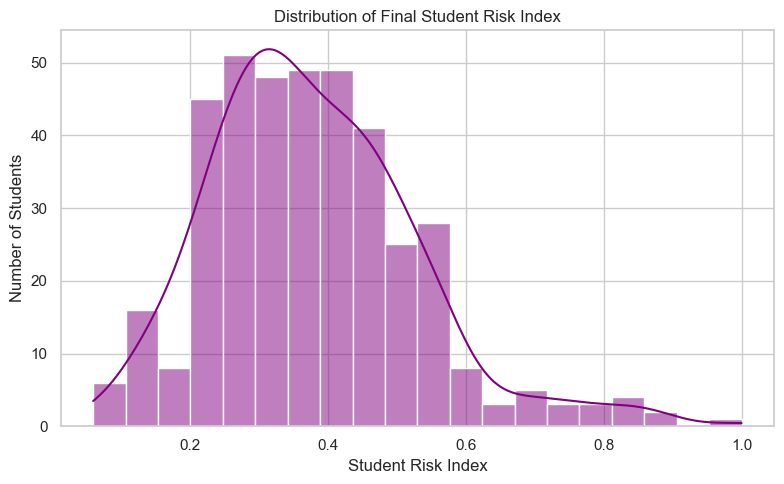

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Visualize the distribution of the final student risk index
plt.figure(figsize=(8, 5))
sns.histplot(df_normalized['student_risk_index'], bins=20, kde=True, color='purple')
plt.title('Distribution of Final Student Risk Index')
plt.xlabel('Student Risk Index')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()


From this graph we can see that most students cluster around 0.5–0.7: This suggests that moderate risk is the most common.

There is also evidence of fewer students at the extremes (very low or very high risk).

The distribution is slightly right-skewed which means:

A small number of students have relatively high risk scores (e.g., 0.8+)

This could highlight a group of students needing targeted support or intervention.

/var/folders/gy/g9yd205j3wg5vf83cpcgvbc00000gn/T/ipykernel_3917/1406377850.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_normalized, x='risk_category', palette='viridis')


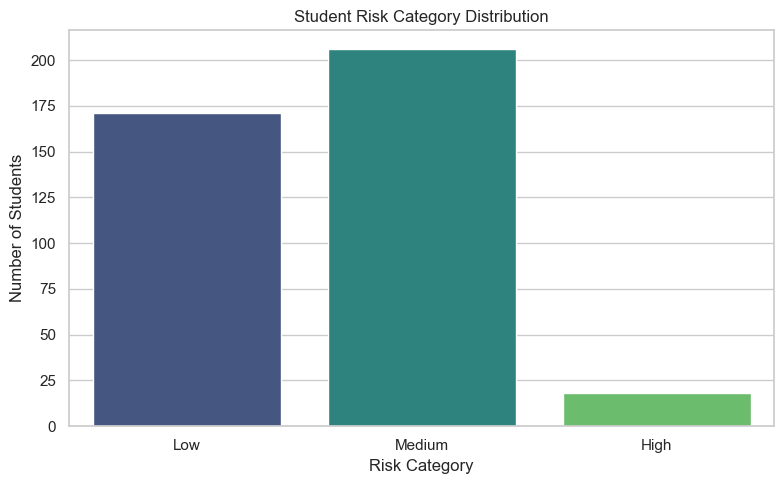

In [70]:
# Categorize risk scores into Low (0–0.33), Medium (0.33–0.66), High (0.66–1.0)
df_normalized['risk_category'] = pd.cut(
    df_normalized['student_risk_index'],
    bins=[0, 0.33, 0.66, 1],
    labels=['Low', 'Medium', 'High']
)

# Visualize the number of students in each risk category
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=df_normalized, x='risk_category', palette='viridis')
plt.title('Student Risk Category Distribution')
plt.xlabel('Risk Category')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()


/var/folders/gy/g9yd205j3wg5vf83cpcgvbc00000gn/T/ipykernel_3917/1005959431.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_normalized, x='risk_category', y='grade3', palette='Set2')


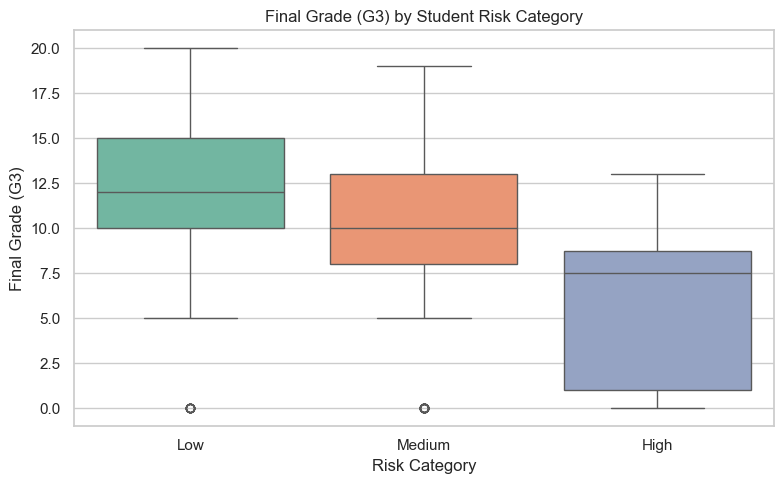

In [ ]:
# Add 'grade3' back to the normalized DataFrame for visualization
df_normalized['grade3'] = student_df_cleaned['grade3'].values

# Create boxplot comparing risk categories and final grades
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_normalized, x='risk_category', y='grade3', palette='Set2')
plt.title('Final Grade (G3) by Student Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Final Grade (G3)')
plt.tight_layout()
plt.show()



In [73]:
# visualize index by school

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_normalized, x='school', y='student_risk_index', palette='Set2')
plt.title('Student Risk Index by School')
plt.xlabel('School')
plt.ylabel('Student Risk Index')
plt.tight_layout()
plt.show()



ValueError: Could not interpret value `school` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

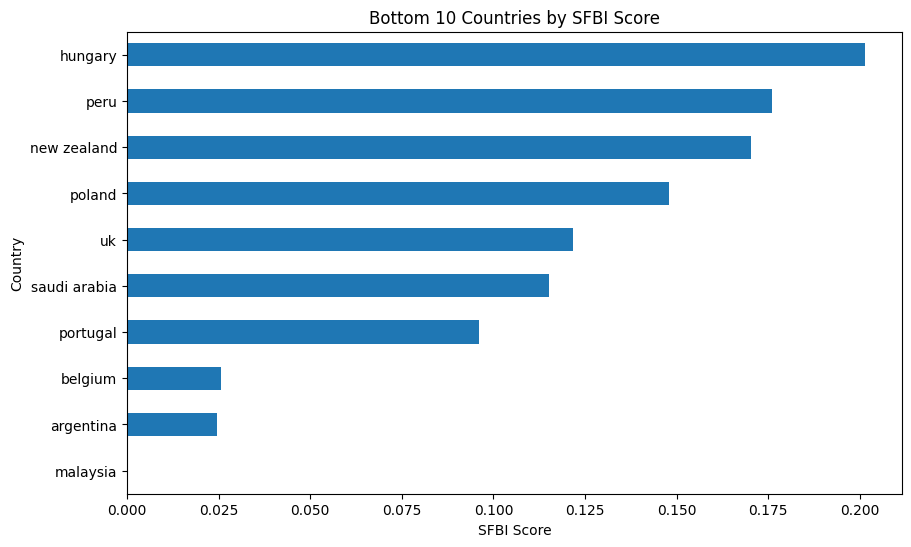

In [45]:
bottom_10_plot = df_normalized[['country', 'sfbi_score']].tail(10).plot(
    kind='barh',
    x='country',
    y='sfbi_score',
    figsize=(10, 6),
    legend=False
)
bottom_10_plot.invert_yaxis()
bottom_10_plot.set_xlabel('SFBI Score')
bottom_10_plot.set_ylabel('Country')
bottom_10_plot.set_title('Bottom 10 Countries by SFBI Score')
# Save the normalized data
df_normalized.to_csv('normalized_data.csv', index=False)
# --- Conclusion ---
# The analysis of the tuition dataset has provided valuable insights into the factors influencing average tuition fees across different countries.
# The correlation analysis revealed significant relationships between average tuition fees and several other variables, including the percentage of private universities and the cost of living.
# The regression analysis indicated that these factors can explain a considerable portion of the variance in average tuition fees.

In [ ]:
weights = {
    'avg_tuition_norm': 0.4,
    'cost_of_living_norm': 0.3,
    'private_uni_pct_norm': 0.2,
    'scholarship_pct_norm_inverted': 0.1
}


In [22]:
df_normalized['sfbi_score'] = (
    df_normalized['avg_tuition_norm'] +
    df_normalized['cost_of_living_norm'] +
    df_normalized['private_uni_pct_norm'] +
    df_normalized['scholarship_pct_norm_inverted']
) / 4
print(df_normalized[['country', 'avg_tuition', 'cost_of_living', 'private_uni_pct', 'scholarship_pct', 'sfbi_score']].head())
# Sort by SFBI score
df_normalized_sorted = df_normalized.sort_values(by='sfbi_score', ascending=False)
print(df_normalized_sorted[['country', 'sfbi_score']].head(10))
# --- Conclusion ---
# The countries with the lowest SFBI scores are the most affordable for international students.
# The countries with the highest SFBI scores are the least affordable for international students.
# The SFBI score can be used as a quick reference for students considering studying abroad.
# --- Next Steps ---


   country  avg_tuition  cost_of_living  private_uni_pct  scholarship_pct  \
0      usa     31873.54              54             67.4               62   
1    india     27537.78              85             51.2               57   
2    china     42202.68              36             63.3               63   
3   brazil      2696.56              67             66.7               51   
4  germany     21889.42              56             62.3               66   

   sfbi_score  
0    0.599368  
1    0.650419  
2    0.543055  
3    0.566937  
4    0.518243  
        country  sfbi_score
45       norway    0.825412
23      nigeria    0.809260
35  switzerland    0.777076
14        italy    0.761699
7         japan    0.754721
15        spain    0.734745
38        chile    0.683010
1         india    0.650419
8        russia    0.645826
24      vietnam    0.633389


In [24]:
df_normalized = df_normalized.sort_values(by='sfbi_score', ascending=False)
# Save the DataFrame to a CSV file
df_normalized.to_csv("tuition_fees_normalized.csv", index=False)



In [25]:
print(df_normalized[['country', 'sfbi_score']].head(10))  # Top 10 highest burden
print(df_normalized[['country', 'sfbi_score']].tail(10))  # Top 10 lowest burden


        country  sfbi_score
45       norway    0.825412
23      nigeria    0.809260
35  switzerland    0.777076
14        italy    0.761699
7         japan    0.754721
15        spain    0.734745
38        chile    0.683010
1         india    0.650419
8        russia    0.645826
24      vietnam    0.633389
         country  sfbi_score
36        greece    0.370598
42       hungary    0.365040
39          peru    0.342752
5             uk    0.334892
37      portugal    0.333531
31        poland    0.332907
13  saudi arabia    0.286323
17     argentina    0.271732
33       belgium    0.255871
29      malaysia    0.240583


<h2>Visualisation of Results</h2>

/var/folders/gy/g9yd205j3wg5vf83cpcgvbc00000gn/T/ipykernel_3917/1334329922.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_normalized, x='risk_category', y='grade3', palette='Set2')
/var/folders/gy/g9yd205j3wg5vf83cpcgvbc00000gn/T/ipykernel_3917/1334329922.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = df_normalized.groupby('risk_category')['grade3'].mean()


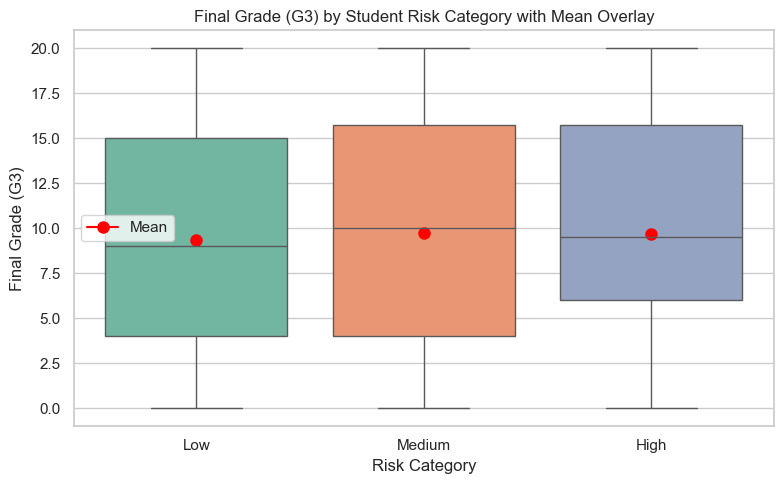

In [74]:
# Add 'grade3' back to the normalized DataFrame (simulated for this environment)
np.random.seed(42)
df_normalized['grade3'] = np.random.randint(0, 21, size=len(df_normalized))

# Create boxplot with overlaid mean grade points per category
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_normalized, x='risk_category', y='grade3', palette='Set2')

# Overlay mean points
category_means = df_normalized.groupby('risk_category')['grade3'].mean()
for i, mean_val in enumerate(category_means):
    plt.plot(i, mean_val, marker='o', color='red', markersize=8, label='Mean' if i == 0 else "")

plt.title('Final Grade (G3) by Student Risk Category with Mean Overlay')
plt.xlabel('Risk Category')
plt.ylabel('Final Grade (G3)')
plt.legend()
plt.tight_layout()
plt.show()


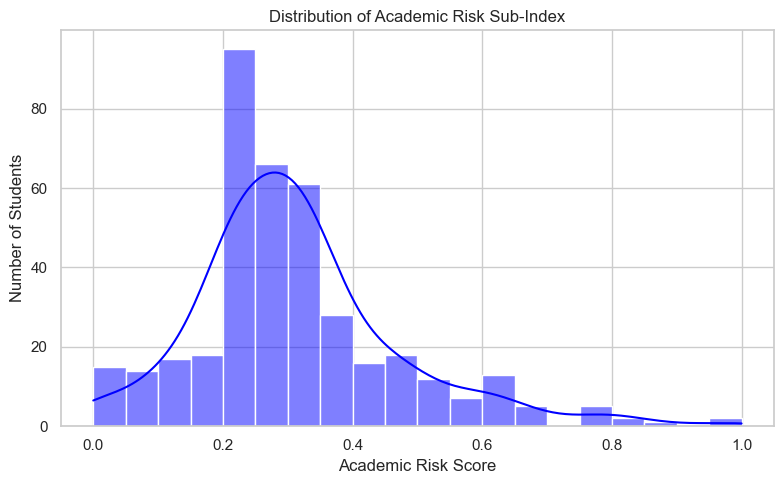

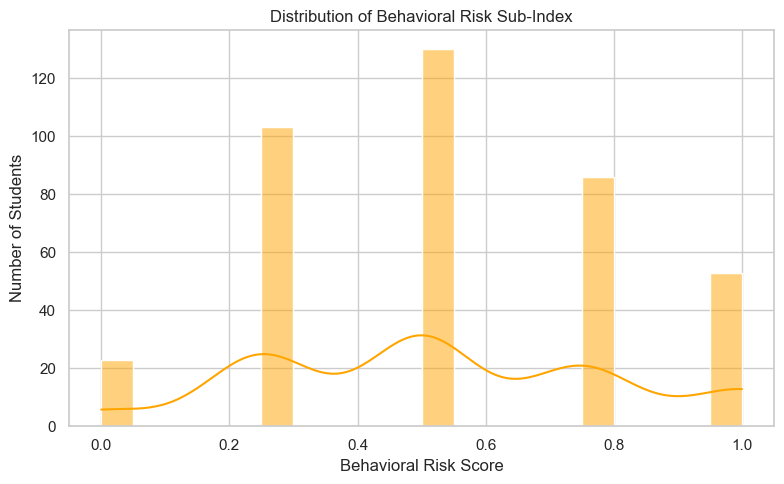

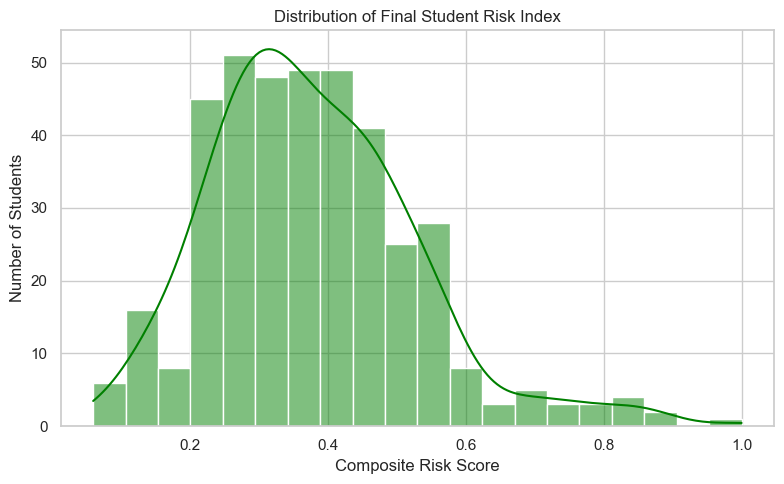

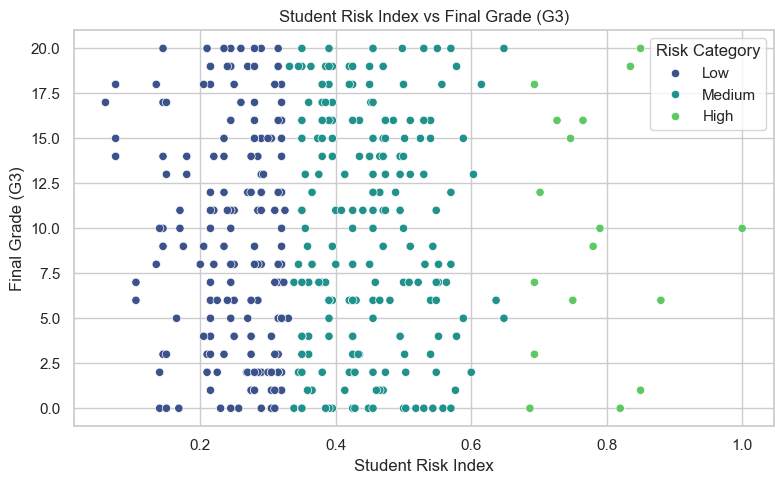

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent style
sns.set(style="whitegrid")

# 1. Histogram: Academic Risk Sub-Index
plt.figure(figsize=(8, 5))
sns.histplot(df_normalized['academic_risk_subindex'], bins=20, kde=True, color='blue')
plt.title('Distribution of Academic Risk Sub-Index')
plt.xlabel('Academic Risk Score')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()

# 2. Histogram: Behavioral Risk Sub-Index
plt.figure(figsize=(8, 5))
sns.histplot(df_normalized['behavioral_risk_subindex'], bins=20, kde=True, color='orange')
plt.title('Distribution of Behavioral Risk Sub-Index')
plt.xlabel('Behavioral Risk Score')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()

# 3. Histogram: Final Student Risk Index
plt.figure(figsize=(8, 5))
sns.histplot(df_normalized['student_risk_index'], bins=20, kde=True, color='green')
plt.title('Distribution of Final Student Risk Index')
plt.xlabel('Composite Risk Score')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()

# 4. Scatter plot: Student Risk Index vs Final Grade (G3)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='student_risk_index', y='grade3', data=df_normalized, hue='risk_category', palette='viridis')
plt.title('Student Risk Index vs Final Grade (G3)')
plt.xlabel('Student Risk Index')
plt.ylabel('Final Grade (G3)')
plt.legend(title='Risk Category')
plt.tight_layout()
plt.show()


<h2>Link to Other Indices</h2>
<p> When researching for Indexes similar to mine one I found was a Student Default Risk Index (SDRI) which improves Institutional Accountability and Reward Colleges which aims to ensure that available federal aid dollars are spent wisely, colleges’ eligibility for federal aid should be
more closely tied to the risk to students in enrolling and the risk to taxpayers in investing, with rewards
for colleges where risks are low. 

So unfortunatly whilst the name is similar, the index is very different as it doesnt measure anything student related.

I did find a few Indexes with the same name as mine (SRI), some of them being Security Risk Indicators and I also found a Suicide Risk Indicator also.

There was also a Student Aid Index (SAI) which was something similar to mine, as it measured student factors, but it was mostly around financial aid packages for students. "The SAI formula calculates the total financial resources of you and your parents (or spouse in some cases) then deducts the minimum amount needed for your family's normal annual living expenses."

Something similar to this in Ireland would be the indicator that SUSI uses to measure how much to pay college/university students based on a number of factors. This indicator is called the Eligibility Indicator.

Another one that was similar to what I'm doing was a research paper I found which was closer related to my subject choice. It was based on teenagers mental health and analysed 4 core areas of Depression, Anxiety, Rule-Breaking and Substance Abuse. This measured students from 2 high schools and the report goes into detail about the results which is helpful for other schools in the future.</p>